In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
# load Dataframe
df = pd.read_csv('Salary_Data.csv')
df

,YearsExperience,Age,Salary
0,1.1,21.0,39343
1,1.3,21.5,46205
2,1.5,21.7,37731
3,2.0,22.0,43525
4,2.2,22.2,39891
5,2.9,23.0,56642
6,3.0,23.0,60150
7,3.2,23.3,54445
8,3.2,23.3,64445
9,3.7,23.6,57189


In [4]:
X = df.drop(columns=['Salary'], axis=1)  # Dataframe type
y = df[['Salary']]                       # Dataframe type

<Axes: xlabel='Age', ylabel='Salary'>

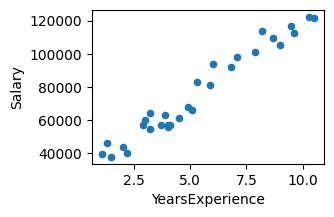

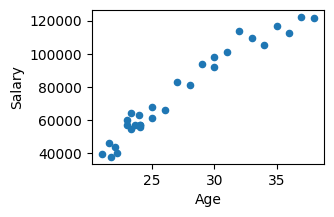

In [5]:
df.plot.scatter(x="YearsExperience", y="Salary", figsize=(3, 2))
df.plot.scatter(x="Age", y="Salary", figsize=(3, 2))

We can observe that the relation between each feature and the target is linear.
Then, a LinearRegression model could be used.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
scalerX = StandardScaler()
scalery = StandardScaler()

X_train_scaled = scalerX.fit_transform(X_train)   # The first time is used fit_transform(), but later, only transform()
y_train_scaled = scalery.fit_transform(y_train)   # Also, both scalers are designed/defined with the train samples.

In [8]:
# Verify that Scalers are working well

scalerX.inverse_transform(X_train_scaled)
#scalery.inverse_transform(y_train_scaled)

array([[10.3, 37. ],
       [ 8.7, 33. ],
       [ 4. , 24. ],
       [ 1.1, 21. ],
       [ 2.2, 22.2],
       [ 5.1, 26. ],
       [ 2.9, 23. ],
       [ 4.1, 24. ],
       [ 4. , 24. ],
       [ 7.9, 31. ],
       [ 1.3, 21.5],
       [ 1.5, 21.7],
       [ 9. , 34. ],
       [ 2. , 22. ],
       [ 7.1, 30. ],
       [ 9.5, 35. ],
       [ 5.9, 28. ],
       [10.5, 38. ],
       [ 6.8, 30. ],
       [ 3.2, 23.3],
       [ 3.9, 23.9],
       [ 4.5, 25. ],
       [ 6. , 29. ],
       [ 3. , 23. ]])

In [9]:
# Applying PCA to the X_train_scaled data. (Here, we reduce/remove to one dimension)

pca = PCA(n_components=1)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)

In [10]:
# The variance ratio/percentage of this PCA reduction
pca.explained_variance_ratio_

array([0.99401434])

The variance ratio is almost 1.0 = 100%, which means that this new reduced feature contains almost full information

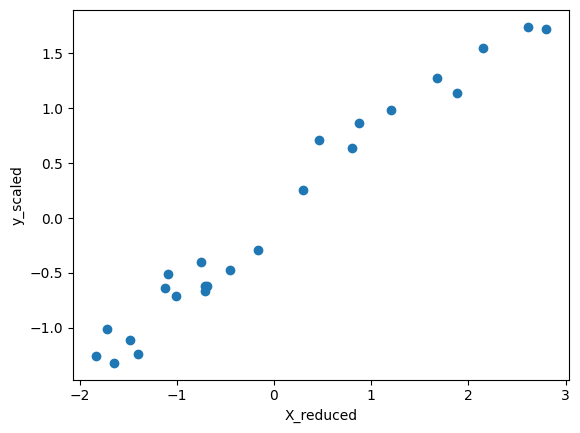

In [11]:
plt.scatter(X_train_scaled_pca, y_train_scaled)
plt.xlabel("X_reduced") # reduced here means scaled and applied by PCA
plt.ylabel("y_scaled")
plt.show()

We observe that relation between this new feature X_reduced and y_scaled keeps as linear

In [12]:
# Now, we can fit our model
model = LinearRegression(n_jobs=-1)
model.fit(X_train_scaled_pca, y_train_scaled)

LinearRegression(n_jobs=-1)

In [13]:
# model score
model_score = model.score(X_train_scaled_pca, y_train_scaled)
print(f'model_score = {round(model_score*100, 1)}%')

model_score = 97.0%


In [14]:
# Performing cross validation for obtaining a more confidence value for model score

from sklearn.model_selection import cross_val_score

# The cross validation is applied on the whole sample.
cv_score = cross_val_score(estimator=model,
                           X=X_train_scaled_pca, y=y_train_scaled, cv=3, n_jobs=-1)

cv_score_mean = round( cv_score.mean()*100, 1 )
cv_score_std  = round( cv_score.std()*100, 1 )

print(f'({cv_score_mean} +- {cv_score_std})%')

(95.7 +- 2.5)%


Due to both results are consistent, then our model is not overfitted.
Now, we can start to make predictions by using the test sample.

In [15]:
def predicting(X):

    X_scaled = scalerX.transform(X)
    X_scaled_pca = pca.transform(X_scaled)

    pred_scaled = model.predict(X_scaled_pca)
    pred = scalery.inverse_transform(pred_scaled)

    return pred.astype(int), X_scaled_pca

In [16]:
def predicting_and_adding_errors(X, y):

    y['pred'], X_scaled_pca = predicting(X)
    y['error'] = y.Salary - y.pred
    y['abs_error'] = abs(y.error)
    y['relative_error'] = y.error*100/y.Salary  # Normalized to True Salary
    y['relative_abs_error'] = y.abs_error*100/y.Salary  # Normalized to True Salary
    return y, X_scaled_pca

In [17]:
y_train, _ =  predicting_and_adding_errors(X_train, y_train)
y_test, X_test_scaled_pca =  predicting_and_adding_errors(X_test, y_test)

In [18]:
# Generate points for the straight line
intercept = model.intercept_
intercept = scalery.inverse_transform(intercept.reshape(-1, 1))
intercept = intercept[0][0]

deltaX = X_test_scaled_pca[1] - X_test_scaled_pca[0]
deltay = y_test.pred.iloc[1] - y_test.pred.iloc[0]

slope = deltay/deltaX

x_values = list( np.linspace(-2, 3, 100) )
y_values = list( slope*x_values + intercept )

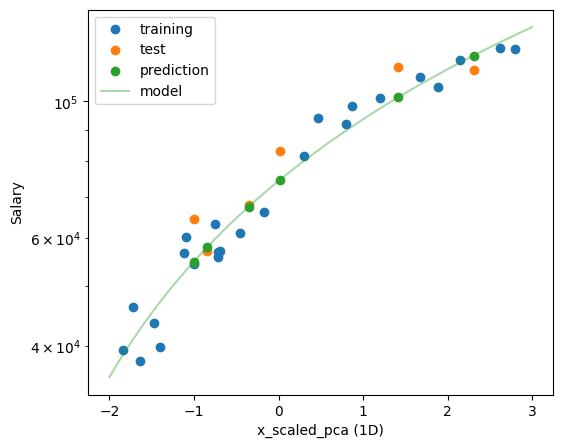

In [19]:
# Plot points from dataset
plt.figure(figsize=(6, 5))

plt.scatter(X_train_scaled_pca, y_train.Salary, label='training', color='tab:blue')
plt.scatter(X_test_scaled_pca,  y_test.Salary, label='test', color='tab:orange')
plt.scatter(X_test_scaled_pca,  y_test.pred, label='prediction', color='tab:green')

# Plot straight line from the linear model
plt.plot(x_values, y_values, label='model', color='tab:green', alpha=0.4)

plt.yscale('log')

plt.xlabel("x_scaled_pca (1D)")
plt.ylabel("Salary")

plt.legend()
plt.show()

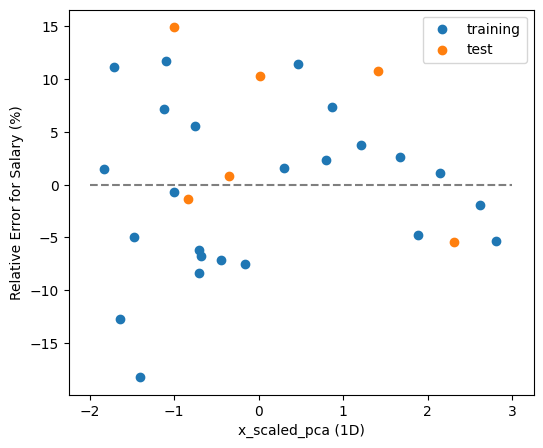

In [20]:
# error plot
plt.figure(figsize=(6, 5))

plt.scatter(X_train_scaled_pca, y_train.relative_error, label='training', color='tab:blue')
plt.scatter(X_test_scaled_pca,  y_test.relative_error,  label='test',     color='tab:orange')
plt.hlines(y=0, xmin=-2, xmax=3, linestyles='--', colors='k', alpha=0.5)

plt.xlabel("x_scaled_pca (1D)")
plt.ylabel("Relative Error for Salary (%)")

plt.legend()
plt.show()

As expected, the relative error is distributed equally in the vertical axis (no bias in the model)

In [21]:
# Finally, if we wish predict on new instances, then we apply:
# First column: YearsExperience; second column: Age
data_new = np.array([[7, 33],
                     [5, 32]])

X_new = pd.DataFrame(data_new, columns=X.columns)

pred, _ = predicting(X_new)
pred

array([[98504],
       [86378]])

If We had used the full dataset (without using PCA), It is possible to obtain better results and model (lower errors),
but It had implied that the execution time would be longer and the model more complex.
This dimensionality reduction is useful when there are many features to deal and the variance is higher (no high loss of information)